## Measuring neuronal co-firing in ephys data

### Import libraries

In [2]:
import os, warnings
import numpy as np
import pandas as pd
import pickle as pickle
import networkx as nx
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Custom libraries
import util_func as uf
import difference_estimation_plot as dpl

# plotting parameters
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['patch.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
sns.set(style='ticks',font_scale=1.4)
# no warning display
warnings.filterwarnings('ignore')

### Set parameters

In [3]:
# directory
homeDir = os.getcwd() # make sure it's the folder level where the script resides
recday = 'mhb10-161111' # recording day name
# global parameters
sampT = 50*1e-6 # spike sampling period 50us / 20kHz
res2eeg = 1250/20000
trackSamp = 32/1250 # tracking sampling period
track2cm = 150/40 # from pixels to cm
# plotting parameters
RED = sns.hls_palette(20,l=.5,s=1)[0]
PURPLE = sns.hls_palette(10,l=.45,s=1)[8]
BLUE = sns.hls_palette(15,l=.6,s=1)[9]#sns.xkcd_palette(['windows blue'])[0]
GREEN = sns.hls_palette(8,l=.4,s=.8)[3]
ORNG = sns.hls_palette(20,l=.5,s=1)[2] #sns.color_palette('husl',8)[1]
GRAY = [0.6,0.6,0.6]
colorsG = [GRAY,RED,ORNG,BLUE,PURPLE,GREEN]
RED_G = sns.color_palette('husl')[0] # used for graph visualisation
# sessions labels
sess_label = {'cpp':['Exposure','Pre-test','+Suc.','+Wat.','CPP test','Re-exposure'],
              'spp':['Exposure','Pre-test','Nov 1','Nov 2','CPP test','Re-exposure'],
              'novel-only':['Exposure','Nov 1a','Nov 1b','Nov 1c','Nov 1d','Re-exposure'],
              'familiar-reward':['Exposure','Fam 2a','Nov 1','Nov 2','Fam 2d','Re-exposure']}

### Load example recording

In [4]:
# Load data from example recording session Exposure -- i.e. exploration of a familiar environment
ses_id = 1 # the Exposure session is the first of the recording day
recDir = homeDir+'/data/recday/'
bsnm = recDir + recday # name of the whole recording day
sesfile = bsnm + '_' + str(ses_id) # session name
# Load session times @ spikes sampling rate (20kHz)
stages = uf.loadStages(bsnm)
sessMaxTimes = np.array(stages['end_t'] - stages['start_t'])
maxT = sessMaxTimes[ses_id-1]
# Load units putative identity
des = uf.loadUnits(sesfile)['des'] # load units putative identity
indP = des=='p1' # principal cells
indI = (des=='b1')|(des=='i1') # interneurons
print(f'We have {np.sum(indP)} putative principal cells and {np.sum(indI)} putative interneurons!')

We have 74 putative principal cells and 6 putative interneurons!


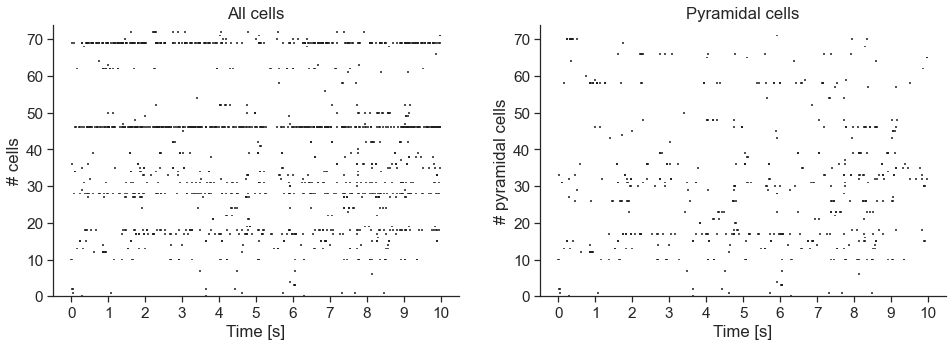

In [5]:
# Load the spiketrains of all the units
res,clu = uf.loadSpikeTimes(sesfile, res2eeg=1)
spiketrains = [res[clu==i] for i in np.unique(clu)] # all neurons
spiketrains_p1 = [res[clu==i] for i in np.unique(clu) if indP[i]] # select only p1 cells

# plot
plt.figure(figsize=(16,5))
ist = 60; ifin = 70 # start/end times in sec
start = ist/sampT; fin = ifin/sampT # start/end times in samples

# raster plot with interneurons
plt.subplot(121)
spk2d = [spkTemp[(spkTemp>start) &\
                 (spkTemp<fin)] for spkTemp in spiketrains] # spikestamps to visualise
plt.eventplot(spk2d,color='k',linelengths=0.5)
plt.ylim(0,len(spiketrains_p1))
plt.title('All cells')
plt.ylabel('# cells')
plt.xticks(np.linspace(start,fin,11),np.arange(ifin-ist+1))
plt.xlabel('Time [s]')
sns.despine()

# raster plot w/o interneurons
plt.subplot(122)
spk2d = [spkTemp[(spkTemp>start) &\
                 (spkTemp<fin)] for spkTemp in spiketrains_p1] # spikestamps to visualise
plt.eventplot(spk2d,color='k',linelengths=0.5)
plt.ylim(0,len(spiketrains_p1))
plt.title('Pyramidal cells')
plt.ylabel('# pyramidal cells')
plt.xticks(np.linspace(start,fin,11),np.arange(ifin-ist+1))
plt.xlabel('Time [s]')
sns.despine()

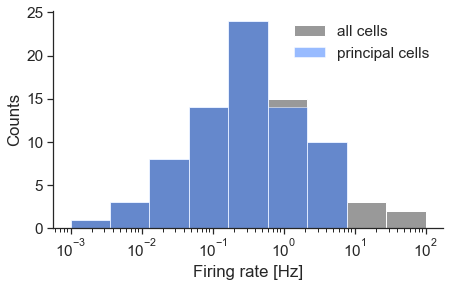

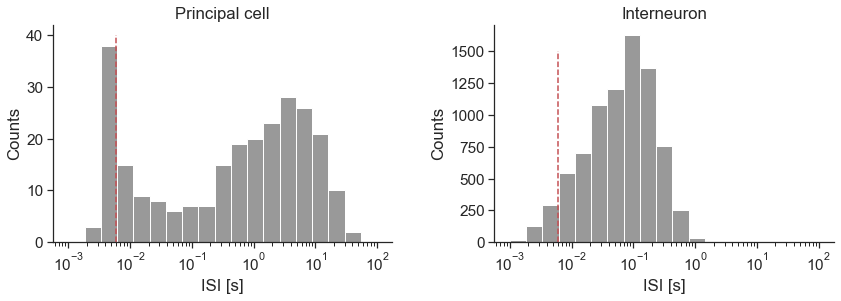

In [6]:
# Visualize the neurons mean firing rate
plt.figure(figsize=(7,4))
# log scale
bins = np.logspace(-3,2,10)
fr = [len(spikes)/(sampT*maxT) for spikes in spiketrains]
plt.hist(fr, bins, color=GRAY, label='all cells')
# only p1s
fr = [len(spikes)/(sampT*maxT) for spikes in spiketrains_p1]
plt.hist(fr, bins, color=BLUE, alpha=.5, label='principal cells')
plt.xscale('log')
plt.xlabel('Firing rate [Hz]')
plt.ylabel('Counts')
plt.legend(frameon=False)
sns.despine()

# Visualise the inter-spike-interval (ISI) distribution of some example neurons
burst_thr = .006 # 6ms isi is the threshold used to tell whether a spike is in a burst
p1ex = np.where(indP)[0][2]
i1ex = np.where(indI)[0][0]
isi = uf.getISI(spiketrains)
plt.figure(figsize=(14,4))
bins = np.logspace(-3,2,20)
plt.subplot(121)
plt.hist(isi[p1ex], bins, color=GRAY)
plt.vlines(6e-3, 0, 40, color='r', linestyle='--')
plt.title('Principal cell')
plt.xscale('log')
plt.ylabel('Counts')
plt.xlabel('ISI [s]')
sns.despine()
plt.subplot(122)
plt.hist(isi[i1ex], bins, color=GRAY)
plt.vlines(6e-3, 0, 1500, color='r', linestyle='--')
plt.title('Interneuron')
plt.xscale('log')
plt.ylabel('Counts')
plt.xlabel('ISI [s]')
sns.despine()
plt.subplots_adjust(wspace=.3)

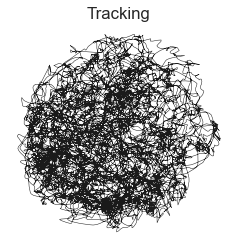

In [7]:
# bin the spiketrains to obtain an activity matrix sampled @1250Hz -- LFP sampling rate
dt = .8 # sampling bin size in ms
dT = (dt*1e-3)/sampT # bin size from ms to samples
std = 50 # gaussian std in samples - 40ms
bins = np.arange(0,maxT,dT)
actmat = uf.bin_spikes(np.asarray(spiketrains_p1).T,bins)
# smooth activity matrix with Gaussian kernel
actmat_s = uf.matGaussianSmooth(actmat.T,std,4*std)[0].T

# load mouse tracking data
track = uf.loadTracking(sesfile)
thrV = 2 * trackSamp * track2cm # speed thr -- 2 cm/s
active = uf.getActiveTrack(track, thrV)
# plot tracking when the animal is active
plt.figure(figsize=(4,4))
plt.plot(track['x'][active], track['y'][active], color='k', alpha=1, linewidth=0.5)
plt.axis('off')
plt.title('Tracking');

#### Look at individual neurons spatial tuning

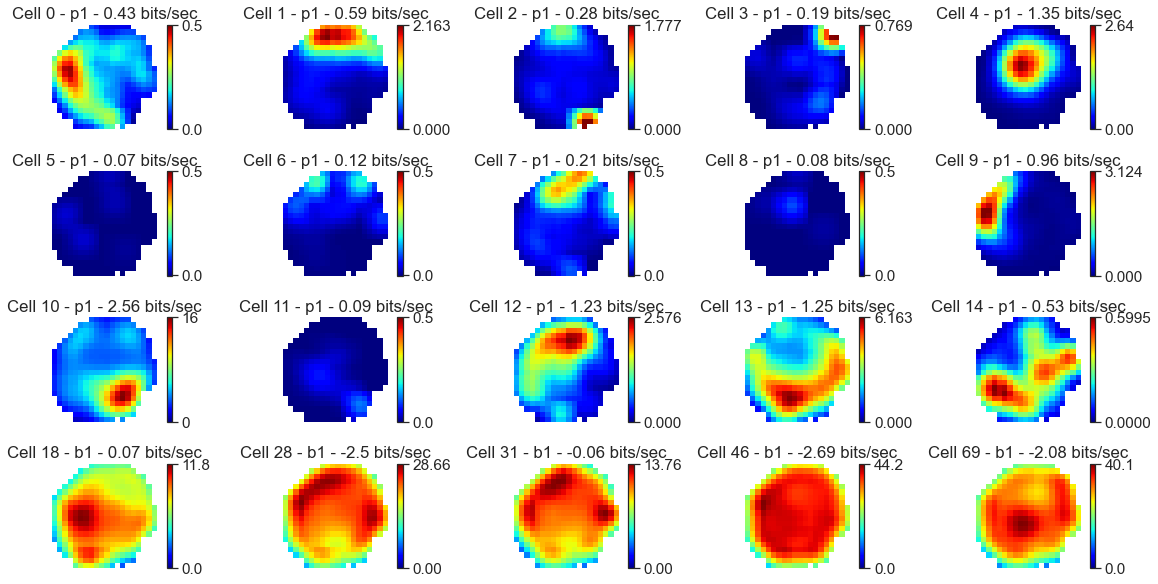

In [12]:
### Visualise some neurons spatial tuning
# select some pyramidal cells and interneurons to display
cid2disp = np.append(np.where(indP)[0][:15],
                     np.where(indI)[0][:5])
plt.figure(figsize=(20,10))
ispk = []; isec = [] # spatial information storage
n = 1 # subplot counter
for cid in range(len(spiketrains)):
    spikes = spiketrains[cid] * res2eeg  # convert to lfp sampling rate @1250Hz
    # obtain the neuron spatial tuning
    occmap, placemap, placemapS, spatialInfo, spatialCoh =\
                uf.getPlaceMap(track, spikes, active, smoothStdCm=4, mazeDim=40)
    ispk.append(spatialInfo[1]) # store neuron's info per spike
    isec.append(spatialInfo[0]) # store neuron's info per second
    # plot
    if cid in cid2disp:
        plt.subplot(4,5,n)
        placemapS[occmap==0] = np.nan
        plt.imshow(placemapS.T,cmap='jet',vmin=-0.001,origin='lower')
        plt.axis('off')
        plt.title(f'Cell {cid} - {des[cid+2]} - {np.round(spatialInfo[0],2)} bits/sec')
        # draw the colorbar
        cbar = plt.colorbar()
        _,vMax = plt.gci().get_clim()
        if vMax<.5: vMax = .5
        plt.clim(vmin=-0.001,vmax=vMax)
        cbar.set_ticks([0,vMax])
        n+=1
plt.subplots_adjust(hspace=.4)

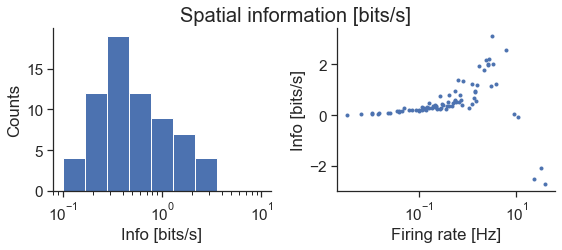

In [9]:
### Plot the neurons' spatial information content
plt.figure(figsize=(9,3))
plt.suptitle('Spatial information [bits/s]')
bins = np.logspace(-1,1,10)
# information / sec
plt.subplot(121)
plt.hist(isec, bins)
plt.xscale('log')
plt.xlabel('Info [bits/s]')
plt.ylabel('Counts')
sns.despine()
# info v firing rate
plt.subplot(122)
fr = [len(spikes)/(sampT*maxT) for spikes in spiketrains]
plt.plot(fr, isec, '.')
plt.xscale('log')
plt.ylabel('Info [bits/s]')
plt.xlabel('Firing rate [Hz]')
sns.despine()
plt.subplots_adjust(wspace=.3)

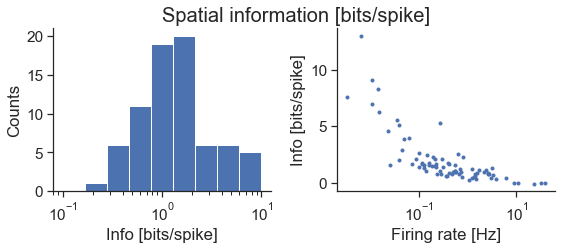

In [10]:
# information / spike
plt.figure(figsize=(9,3))
plt.suptitle('Spatial information [bits/spike]')
plt.subplot(121)
plt.hist(ispk, bins)
plt.xscale('log')
plt.xlabel('Info [bits/spike]')
plt.ylabel('Counts')
sns.despine()
# info v firing rate
plt.subplot(122)
fr = [len(spikes)/(sampT*maxT) for spikes in spiketrains]
plt.plot(fr, ispk, '.')
plt.xscale('log')
plt.ylabel('Info [bits/spike]')
plt.xlabel('Firing rate [Hz]')
sns.despine()
plt.subplots_adjust(wspace=.3)

#### Obtain neuronal co-firing graphs using different methods

In [9]:
# extraction of theta cycles timestamps
thetafile = sesfile + '.theta.cycles'
thetacycles = np.load(thetafile) # format: (theta cycle id, cycle point references)
theta = np.zeros(actmat.shape[0], dtype=bool) # boolean vector to index theta samples
for t in thetacycles: theta[t[0]:t[-1]] = True
# upsample (linearly) active tracking indexes to match theta sampling rate
downx = np.linspace(0,maxT,len(active))
upx = np.linspace(0,maxT,actmat.shape[0])
f = interp1d(downx,active)
active_up = f(upx) # upsampled
theta_active = np.logical_and(theta, active_up) # bool indexes for theta and active movement
# actmat filtered by active samples, sampled @1250Hz (LFP rate)
actmat_a = actmat_s[theta_active]
# theta-binned actmat
actmat_the = uf.get_actmat_the(actmat, thetacycles)

In [12]:
# binless smoothed correlation graph @1250Hz
Gcorr = uf.corrGraph(actmat_a)
print('Obtained correlation graph...')
# theta-cycle-binned correlation graph
Gtheta = uf.corrGraph(actmat_the)
print('Obtained theta-binned correlation graph...')
# GLM graph -- allows us to separate the effect of individual cells from the population drive
Gglm,Gpop = uf.GLMgraph_lin(actmat_the, symm=0) # Gglm=individual cell coupling -- Gpop=population drive effects
print('Obtained theta-binned GLM graph...')

Obtained correlation graph...
Obtained theta-binned correlation graph...
Obtained theta-binned GLM graph...


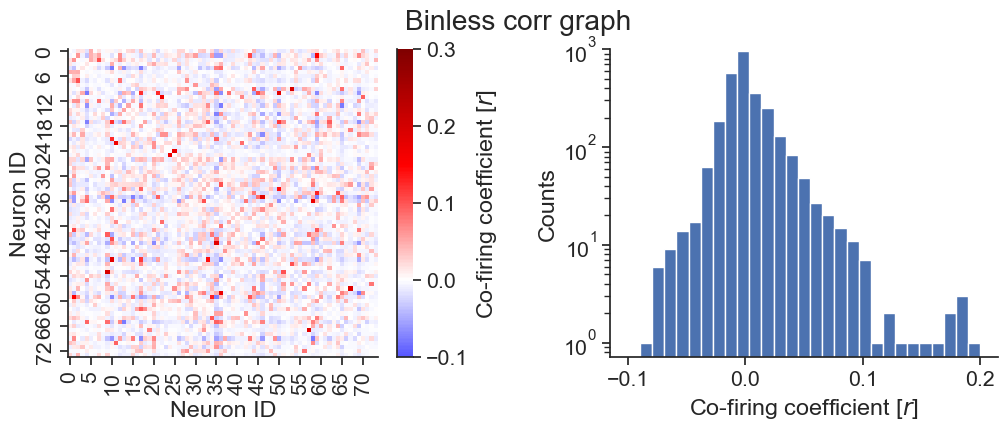

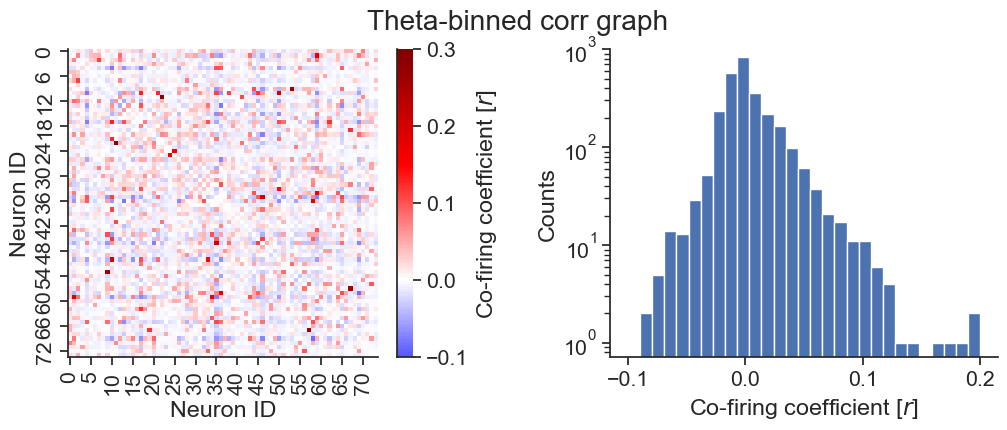

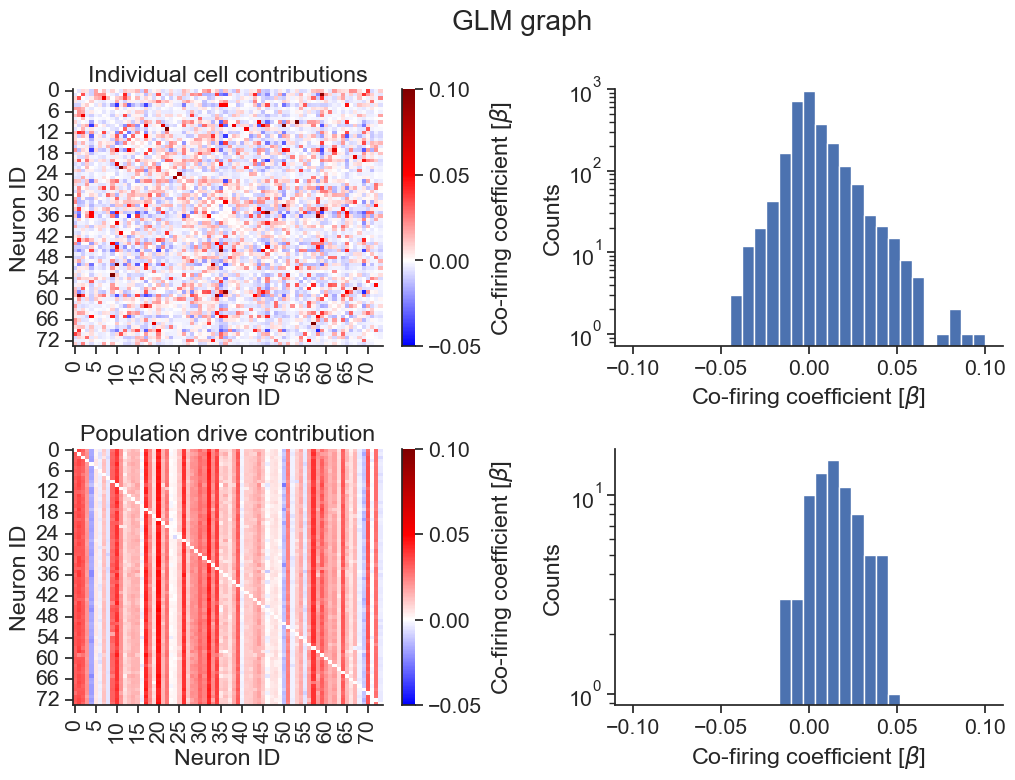

In [13]:
# Plot co-firing graphs
bins = np.linspace(-.1,.2,30)
# binless correlation graph @1250Hz
plt.figure(figsize=(12,4))
plt.suptitle('Binless corr graph')
plt.subplot(121)
g = Gcorr
sns.heatmap(g, cbar=True, vmax=.3, vmin=-.1, center=0,
            cmap='seismic', cbar_kws={'label':'Co-firing coefficient [$r$]'})
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')
plt.subplot(122)
plt.hist(g[np.triu_indices_from(g)], bins=bins);
plt.yscale('log')
plt.ylim(0,1e3)
plt.ylabel('Counts')
plt.xlabel('Co-firing coefficient [$r$]')
sns.despine()
plt.subplots_adjust(wspace=.4)

# theta binned graph
plt.figure(figsize=(12,4))
plt.suptitle('Theta-binned corr graph')
plt.subplot(121)
g = Gtheta
sns.heatmap(g, cbar=True, vmax=.3, vmin=-.1, center=0,
            cmap='seismic', cbar_kws={'label':'Co-firing coefficient [$r$]'})
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')
plt.subplot(122)
plt.hist(g[np.triu_indices_from(g)], bins=bins)
plt.yscale('log')
plt.ylim(0,1e3)
plt.ylabel('Counts')
plt.xlabel('Co-firing coefficient [$r$]')
sns.despine()
plt.subplots_adjust(wspace=.4)

# GLM individual contribution graph
plt.figure(figsize=(12,8))
plt.suptitle('GLM graph')
plt.subplot(221)
g = Gglm
sns.heatmap(g, cbar=True, vmax=.1, vmin=-.05, center=0,
            cmap='seismic', cbar_kws={'label':'Co-firing coefficient [$\\beta$]'})
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')
plt.title('Individual cell contributions')
plt.subplot(222)
bins = np.linspace(-.1,.1,30)
plt.hist(g[np.triu_indices_from(g)], bins=bins)
plt.yscale('log')
plt.ylim(0,1e3)
plt.ylabel('Counts')
plt.xlabel('Co-firing coefficient [$\\beta$]')
sns.despine()
# GLM population drive
plt.subplot(223)
g = Gpop
sns.heatmap(g, cbar=True, vmax=.1, vmin=-.05, center=0,
            cmap='seismic', cbar_kws={'label':'Co-firing coefficient [$\\beta$]'})
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')
plt.title('Population drive contribution')
plt.subplot(224)
plt.hist(g.mean(0), bins=bins)
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('Co-firing coefficient [$\\beta$]')
sns.despine()
plt.subplots_adjust(hspace=.4, wspace=.4)

## Topological analysis of hippocampal CA1 neural cofiring networks
#### Gava et al, 2021 -- [link](https://www.mrcbndu.ox.ac.uk/sites/default/files/Gava%20et%20al%202021%20Nat%20Neurosci_In%20press.pdf)

### Load example binless co-firing graphs used in the paper/study and compute their topological measures

One co-firing graph was obtained per session (e.g. enclosure, pre-test, re-exposure, ...), each of them is represented by its $NxN$ adjacency matrix (N is the number of principal cells recorded on the day). The first four session are performed in succession, while there is an hour break before the last two.

Each of the matrix elements $(i,j)$ was obtained as the Pearson correlation coefficient between the spiketrains of the neuron $i$ and $j$, each smoothed through convolution with a $40ms$ Gaussian.

In [10]:
### Load names of precomputed principal cells co-firing graphs (i.e. co-firing matrices)
# obtain list of recording days
for _,folders,file in os.walk(homeDir+'/data/networks'):
    dataList = file
# initialise batch variables
exp_names = []
w = {}; clu = {}; plw = {}; netD = {}

# BATCH WORK
for dd,dataname in enumerate(dataList): # loop over recording days / experiments
    # load data for single exp
    exp_name = dataname.split('.')[0].split('_')[-1] # obtain the experiment label
    exp_names.append(exp_name)
    bsnm = dataname.split('_')[0]
    print(f'\n- processing {exp_name} example...')
    # load data
    with open(homeDir+'/data/networks/'+dataname,'rb') as f:
        data = pickle.load(f)
    allKEYS = list(data.keys())
    allKEYS_ = allKEYS.copy() # make a deep copy for extra looping within the loop
    print(f'# p1 neurons: {data[allKEYS[0]].shape[0]}\nSessions to analyse: {allKEYS}')
    w[exp_name] = {}; clu[exp_name] = {}; plw[exp_name] = {}; netD[exp_name] = {}
    # loop over sessions
    for k,k2 in zip(sess_label[exp_name],allKEYS): # loop over sessions
        g = data[k2]
        w[exp_name][k] = g
        # networkx measures
        graph = nx.Graph(g)
        clu[exp_name][k] = list(uf.clustering(graph,weight='weight').values())
        plw[exp_name][k] = uf.wNetGeoPathLength(g.copy())
        # matrix topological distance analysis
        netRef = g + np.identity(g.shape[0]) # fill diaginal to ensure matrix positivness
        keys2 = zip(sess_label[exp_name],allKEYS_) # indeces to loop over sessions again
        for kk,kk2 in keys2: # loop again over sessions to obtain topological distances
            if kk==sess_label[exp_name][0]: # initialise dict if first iter
                netD[exp_name][k] = {} 
            g = data[kk2] # other network from which to measure the distance
            if kk==k: # self distance case (add noise to avoid distance of 0)
                perturb = uf.symmMatPerturb(g,scale=1); np.fill_diagonal(perturb,0)
                gPosDef = g + np.identity(g.shape[0])
                comp = gPosDef + perturb
                netD[exp_name][k][kk] = uf.distRiemLE(netRef,comp)
            else: # different session from the reference one
                gPosDef = g + np.identity(g.shape[0])
                netD[exp_name][k][kk] = uf.distRiemLE(netRef,gPosDef)
print(f'\nThe available experiments are {exp_names}')


- processing spp example...
# p1 neurons: 70
Sessions to analyse: ['f 1_1', 'n1n2 pretest_2', 'n 1_3', 'n 2_4', 'n1n2 test_5', 'f 1_6']

- processing novel-only example...
# p1 neurons: 47
Sessions to analyse: ['f 1_1', 'n 1a_2', 'n 1b_3', 'n 1c_4', 'n 1d_5', 'f 1_6']

- processing cpp example...
# p1 neurons: 80
Sessions to analyse: ['f 1_1', 'n1n2 pretest_2', 'n2 suc_3', 'n1 wat_4', 'n1n2 test_5', 'f 1_6']

- processing familiar-reward example...
# p1 neurons: 74
Sessions to analyse: ['f 1_1', 'f 2a_2', 'f 2suc_3', 'f 2wat_4', 'f 2d_5', 'f 1_6']

The available experiments are ['spp', 'novel-only', 'cpp', 'familiar-reward']


### Visualise one example co-firing graph and its adjacency matrix

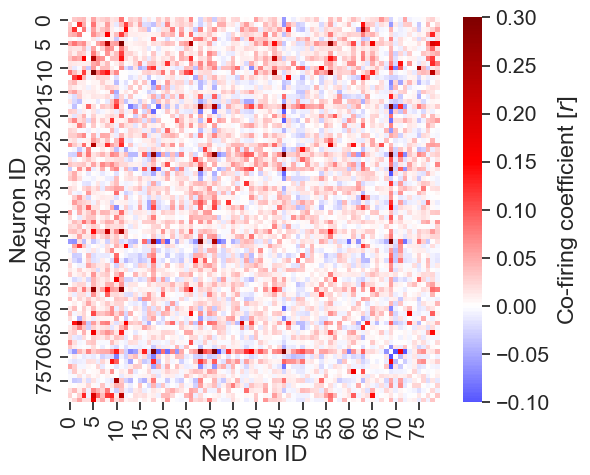

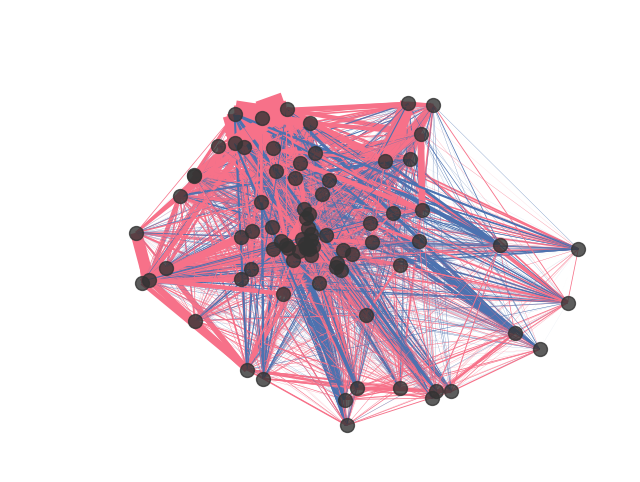

In [15]:
# select co-firing graph to visualise
EXP = 'cpp' # recording day index -- CPP
SID = 5 # re-exposure session
K = sess_label[EXP][SID] # session index -- exposure
# obtain the graph
adjmat = w[EXP][K]
graph = nx.Graph(adjmat)
# plot adj matrix
plt.figure(figsize=(6,5))
sns.heatmap(adjmat, cbar=True, vmax=.3, vmin=-.1, center=0,
            cmap='seismic', cbar_kws={'label':'Co-firing coefficient [$r$]'})
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')
# visualise graph with networkX
plt.figure(figsize=(8,6))
uf.plotWeightedGraph(adjmat, graphType='spring', scale=0.4, Labels=0,
                     nodeC=[.2,.2,.2], nodeSize=100, posC=RED_G)

Exposure
Session Exposure: co-firing S 0.07 | geo path length 84.2 | clust coeff -0.001
Pre-test
Session Pre-test: co-firing S 0.06 | geo path length 73.2 | clust coeff 0.006
+Suc.
Session +Suc.: co-firing S 0.09 | geo path length 59.4 | clust coeff 0.006
+Wat.
Session +Wat.: co-firing S 0.10 | geo path length 79.2 | clust coeff 0.030
CPP test
Session CPP test: co-firing S 0.13 | geo path length 52.5 | clust coeff 0.121
Re-exposure
Session Re-exposure: co-firing S 0.10 | geo path length 67.6 | clust coeff 0.056


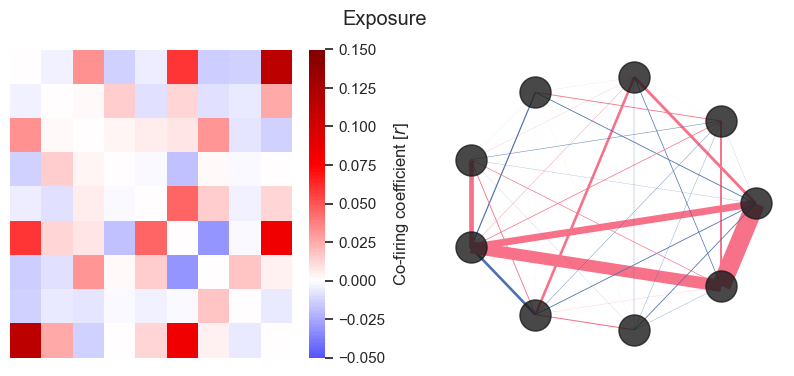

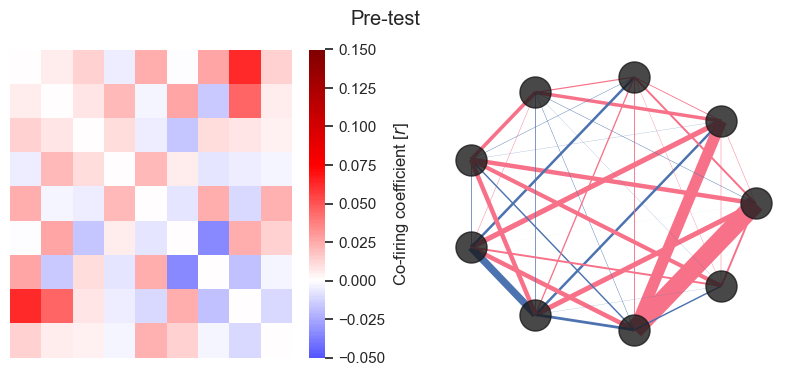

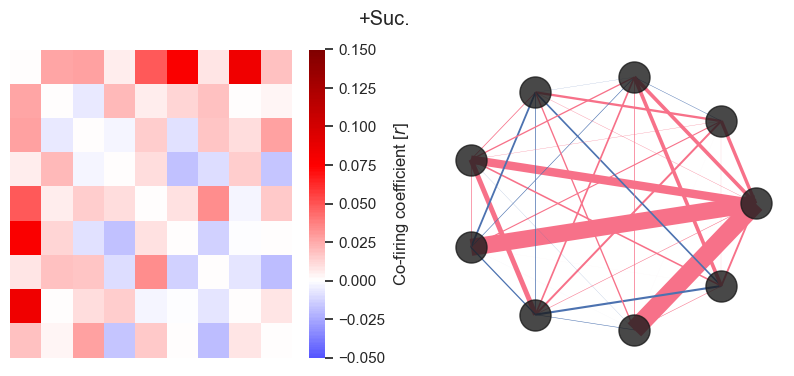

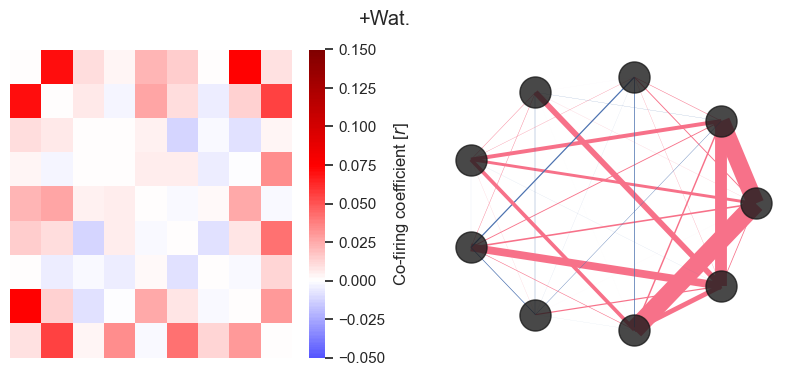

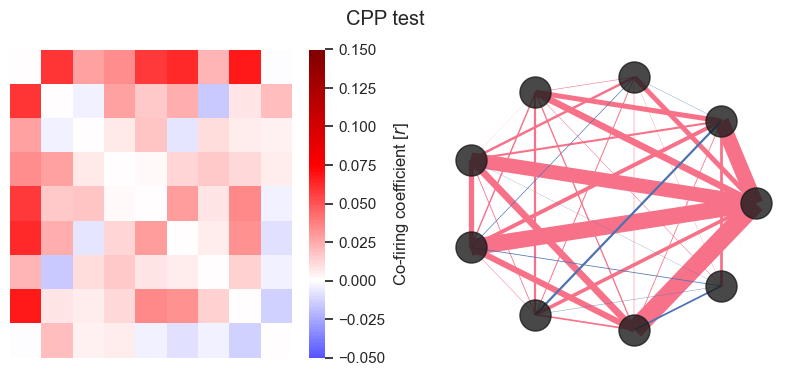

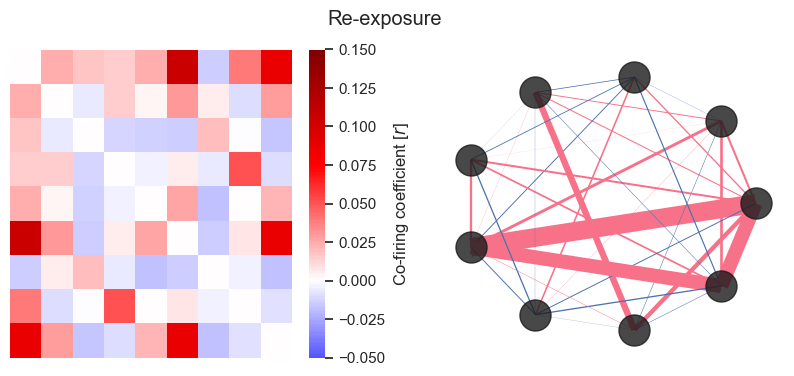

In [18]:
### Plot subgraphs across sessions
sns.set(style='ticks',font_scale=1)
nc = 7 # number of cells to display
for k in sess_label[EXP]:
    print(k)
    adjmat = w[EXP][k] #  graph copy to obtain indiv units to visualise
    # obtain indice of most correlated units to form subgraph to display
    if k==sess_label[EXP][0]: # use exposure session as reference
        indd = np.argsort(np.std(np.abs(adjmat),0))[::-1] # select the nodes with the largest std
        IND = [10,52,14,65,59,50,23,25,49] # picked from visual inspection
        IX = np.ix_(IND,IND) # matrix indeces
    # obtain subgraph measures
    GGG = adjmat[IX] # extract  subgraph
    G = nx.Graph(GGG)
    avgS = np.mean(GGG.sum(0)) # average neurons co-firing strength
    avgClu = np.mean(list(uf.clustering(G,weight='weight').values())) # average clustering
    avgPL = np.nanmean(uf.wNetGeoPathLength(GGG.copy())) # average PL
    # PLOTTING
    plt.figure(figsize=(10,4))
    plt.suptitle(k)
    plt.subplot(121)
    sns.heatmap(GGG, cmap='seismic', center=0, vmin=-.05 ,vmax=.15,
                cbar_kws={'label':'Co-firing coefficient [$r$]'})
    plt.axis('off');
    plt.subplot(122)
    uf.plotWeightedGraph(GGG, graphType='circ', scale=1.5, nodeC='k', posC=RED_G)
    print('Session %s: co-firing S %.2f | geo path length %.1f | clust coeff %.3f'\
          %(k,avgS,avgPL,avgClu))

## Visualise the examples co-firing topology dynamics over sessions

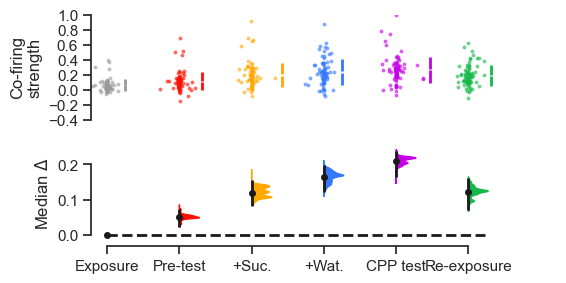

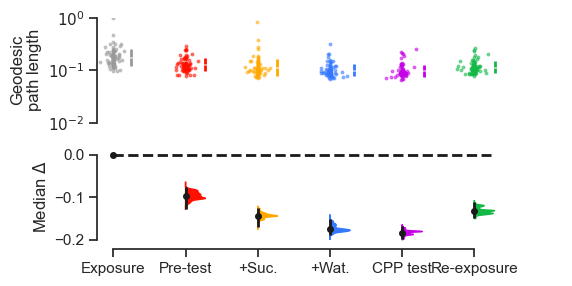

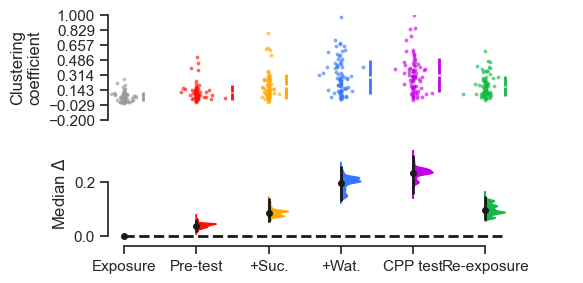

In [19]:
### Visualise the cofiring topological measures across sessions

# choose which dataset to visualise
EXP = 'cpp'
KEYS = sess_label[EXP]

# NETWORK STRENGTH
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = np.nansum(w[EXP][k],1)
# normalise it
norm = np.max([np.max(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = m_out[k]
ax, m, p = dpl.estimation_plot(df, ci=.99, nsh=1000, operation=np.median,
                           swarmPlot_kw={'label':'Co-firing\nstrength'},
                           figsize=(6,3), color_palette=colorsG, paired=1, trend=0)
ymin = -0.4; ymax = 1
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,8))
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$')

# GEO PATH LENGTH
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = np.nanmean(plw[EXP][k],1)
# normalise it
norm = np.max([np.nanmax(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
x = [m_out[k] for k in KEYS]
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = x[nk]
ax, m, p = dpl.estimation_plot(df, ci=.99, nsh=1000, operation=np.median,
                           swarmPlot_kw={'label':'Geodesic\npath length'},
                           figsize=(6,3), color_palette=colorsG, paired=1, trend=0)
# ymin = -2; ymax = 0
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,3))
ax[0].set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^0$'])
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$')

# CLUSTERING
m_norm = {}
m_out = {}
for k in KEYS:
    m_out[k] = []
    m_norm[k] = clu[EXP][k]
# normalise it
norm = np.max([np.nanmax(m_norm[k]) for k in KEYS])
for k in KEYS:
    m_out[k] = m_norm[k]/norm
# display
df = pd.DataFrame()
for nk,k in enumerate(KEYS): df[sess_label[EXP][nk]] = m_out[k]
# plotting
ax, m, p = dpl.estimation_plot(df, ci=.99, nsh=1000, operation=np.median,
                           swarmPlot_kw={'label':'Clustering\ncoefficient'},
                           figsize=(6,3), color_palette=colorsG, paired=1, trend=0)
ymin = -0.2; ymax = 1
ax[0].set_xticks([])
ax[0].set_yticks(np.linspace(ymin,ymax,8))
ax[0].set_ylim(ymin,ymax)
ax[1].set_ylabel('Median $\Delta$');

### Topological distance analysis

Visualise the distance between co-firing graph across session, for each of the experimental protocols

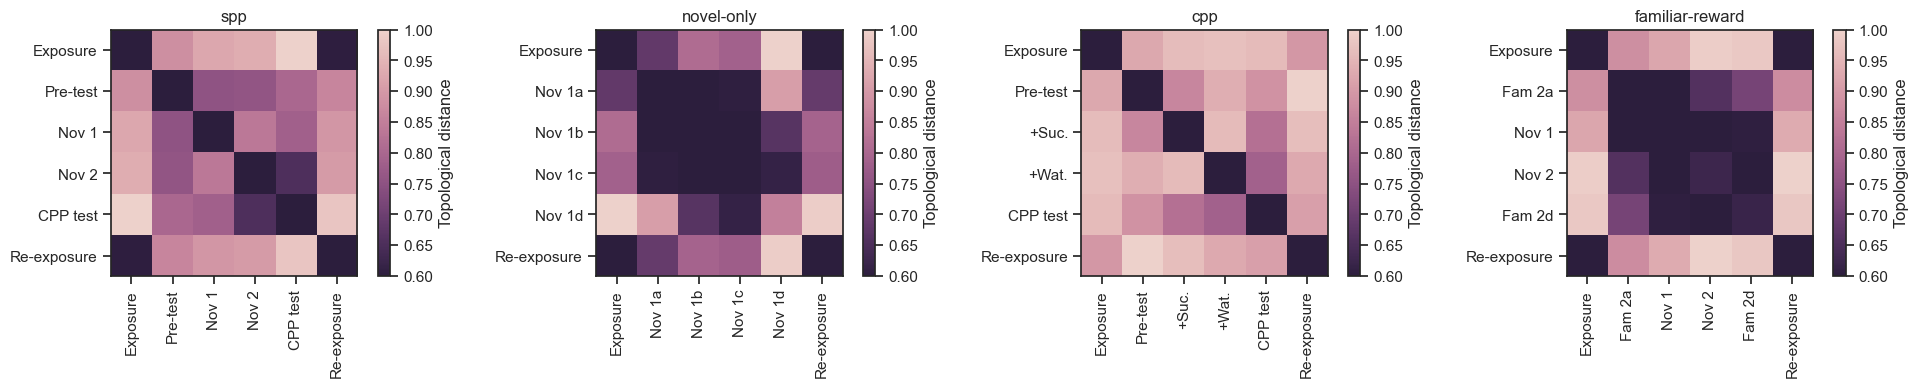

In [36]:
plt.figure(figsize=(24,3.2))
for ne,EXP in enumerate(exp_names): # loop over datasets
    KEYS = sess_label[EXP]
    topoDmat = np.zeros((len(KEYS),len(KEYS)))
    for nk,k in enumerate(KEYS):
        # obtain row of the topo distance matrix
        topoDmat[:,nk] = np.asarray([netD[EXP][k][kk] for kk in KEYS])
    topoDmat /= topoDmat.max() # normalise the distances
    plt.subplot(1,4,ne+1)
    plt.title(EXP)
    plt.imshow(topoDmat,cmap=sns.cubehelix_palette(20,reverse=True,as_cmap=True))
    cbar = plt.colorbar(); plt.clim(0.6,1); cbar.set_label('Topological distance') # colorbar
    plt.xticks(range(6),sess_label[EXP],rotation=90); plt.yticks(range(6),sess_label[EXP])

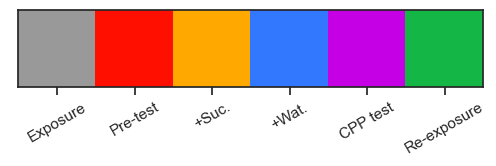

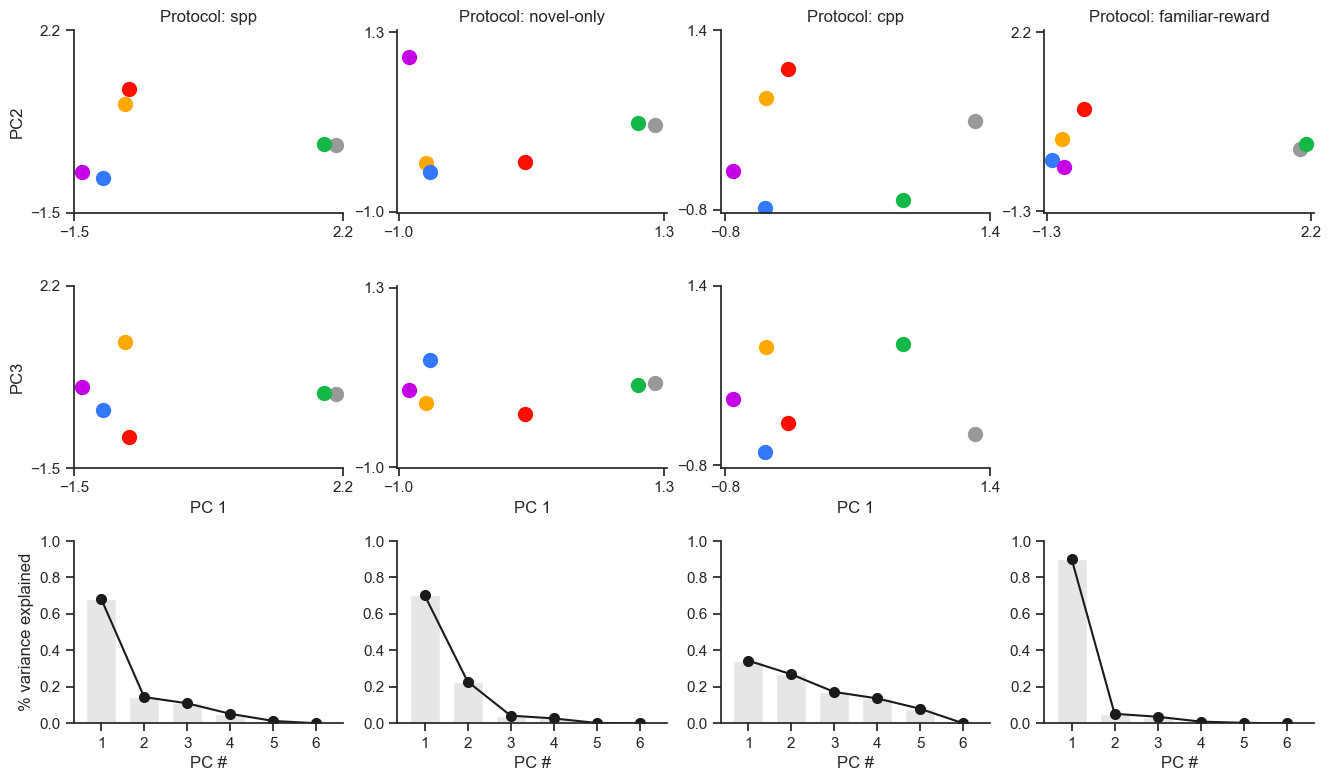

In [34]:
# pca projection of topological distance matrices
# display sessions labels
sns.palplot(colorsG)
plt.xticks(range(6), sess_label['cpp'], rotation=30);

sns.set(style='ticks',font_scale=1)
plt.figure(figsize=(16,9))
for ne,EXP in enumerate(exp_names): # loop over datasets
    KEYS = sess_label[EXP]
    topoDmat = np.zeros((len(KEYS),len(KEYS)))
    for nk,k in enumerate(KEYS):
        temp = np.asarray([netD[EXP][k][kk] for kk in KEYS]) # obtain row of the matrix
        topoDmat[:,nk] = temp#/np.max(temp) # normalise
    # Apply PCA to the topological distance matrices to visualise the sessions in a low-dim space
    pca = PCA(n_components=len(KEYS))
    xtr = pca.fit_transform(topoDmat)
    # plot projections: PC1 V PC2
    plt.subplot(3,4,ne+1)
    for i in range(len(xtr)):
        plt.plot(xtr[i,0],xtr[i,1], 'o', color=colorsG[i], markersize=10)
    plt.title(f'Protocol: {EXP}')
    MIN = np.min(xtr[:,0])-0.1; MAX = np.max(xtr[:,0])+0.1
    plt.xlim(MIN,MAX); plt.ylim(MIN,MAX)
    if not ne: plt.ylabel('PC2')
    plt.xticks([np.round((MIN)*10)/10,np.round(MAX*10)/10])
    plt.yticks([np.round(MIN*10)/10,np.round(MAX*10)/10])
    sns.despine()
    # PC1 v PC3
    if ne<3:
        plt.subplot(3,4,ne+5)
        for i in range(len(xtr)):
            plt.plot(xtr[i,0],xtr[i,2], 'o', color=colorsG[i], markersize=10)
        MIN = np.min(xtr[:,0])-0.1; MAX = np.max(xtr[:,0])+0.1
        plt.xlim(MIN,MAX); plt.ylim(MIN,MAX)
        plt.xlabel('PC 1')
        if not ne: plt.ylabel('PC3')
        plt.xticks([np.round((MIN)*10)/10,np.round(MAX*10)/10])
        plt.yticks([np.round(MIN*10)/10,np.round(MAX*10)/10])
        sns.despine()
    # plot PCs variance explained
    plt.subplot(3,4,ne+9)
    toP = pca.explained_variance_ratio_
    plt.plot(toP,'ko',markersize=7)
    plt.plot(toP,'k')
    plt.bar(range(len(toP)), toP, width=0.7, color=[0.9,0.9,0.9])
    sns.despine()
    plt.xlabel('PC #')
    if not ne: plt.ylabel('% variance explained')
    plt.xticks(range(6), range(1,7))
    plt.ylim(0,1)
    sns.despine()
plt.subplots_adjust(hspace=.4)


PCA reveals that the main difference across co-firing graphs in all datasets is Familiar v Novel (PC1), which explains all the variance in the familiar reward protocol (interestingly in the novel only protocol it also singles out the first novel session, were the novelty response is strongest).

PC2 instead tends to separate the novel sessions among themselves, and their separation seem to correlate with the complexity of the task.

The CPP task shows the most high-dimensional structure, highlighting how the two familiar session have different co-firing topologies after the CPP protocol.